<a href="https://colab.research.google.com/github/xixilili/MSDS_458_Public/blob/master/MSDS458_Assignment_03/MSDS458_Assignment_03_Experiment_D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Experiment D: 1D CNN

### Mount Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


### Load Package

In [2]:
import datetime
from packaging import version
from collections import Counter
import numpy as np
import pandas as pd
import time

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import accuracy_score

import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds

### Load and Process Data

In [3]:
# register  ag_news_subset so that tfds.load doesn't generate a checksum (mismatch) error
!python -m tensorflow_datasets.scripts.download_and_prepare --register_checksums --datasets=ag_news_subset

# Example Approaches to Split Data Set
# dataset, info = tfds.load('ag_news_subset', with_info=True,  split=['train[:]','test[:1000]', 'test[1000:]'],
dataset, info = tfds.load('ag_news_subset', with_info=True,  split=['train[:95%]','train[95%:]', 'test[:]'],
# dataset, info = tfds.load('ag_news_subset', with_info=True,  split=['train[:114000]','train[114000:]', 'test[:]'],
                          as_supervised=True)
train_dataset, validation_dataset, test_dataset = dataset
# train_dataset, test_dataset = dataset['train'],dataset['test']

2022-02-20 03:10:06.194115: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
I0220 03:10:06.194406 140344973703040 download_and_prepare.py:200] Running download_and_prepare for dataset(s):
ag_news_subset
I0220 03:10:06.353914 140344973703040 dataset_info.py:434] Load pre-computed DatasetInfo (eg: splits, num examples,...) from GCS: ag_news_subset/1.0.0
I0220 03:10:06.523741 140344973703040 dataset_info.py:361] Load dataset info from /tmp/tmpfgeg3pz8tfds
I0220 03:10:06.525810 140344973703040 download_and_prepare.py:138] download_and_prepare for dataset ag_news_subset/1.0.0...
I0220 03:10:06.526252 140344973703040 dataset_builder.py:357] Generating dataset ag_news_subset (/root/tensorflow_datasets/ag_news_subset/1.0.0)
Dl Completed...: 0 url [00:00, ? url/s]
Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]I0220 03:10:06.794086 140344973703040 download_manager.py:476] 

In [4]:
BUFFER_SIZE = 10000
BATCH_SIZE = 2560
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)
validation_dataset = validation_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)

### Explore Vocab

In [5]:
def explore_vocab(train_dataset,encoder):
  doc_sizes = []
  corpus = []
  for example, _ in train_dataset.as_numpy_iterator():
    enc_example = encoder(example)
    doc_sizes.append(len(enc_example))
    corpus+=list(enc_example.numpy())
  return  corpus, doc_sizes

### Compile, Train Model

In [6]:
def namestr(obj, namespace):
  for name in namespace:
    if namespace[name] is obj:
      return name

In [13]:
import datetime as dt

def compile_train_model(model, epoch):
  #compile model
  model.compile(optimizer="adam"
              ,loss="SparseCategoricalCrossentropy" # if we set from_logits=True we don not have specify a softmax activation function in the last layer
              ,metrics=['accuracy'])

  start_datetime = dt.datetime.now()

  #train model  
  history = model.fit(train_dataset
                    ,epochs = epoch
                    ,validation_data=validation_dataset
                    ,callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)]
                    )


  #evaluate model
  loss, accuracy = model.evaluate(test_dataset)
  print('test set accuracy: ', accuracy * 100)

  runtime = (dt.datetime.now() - start_datetime).total_seconds()

  #training and validation performance metrix
  history_dict = history.history
  history_df=pd.DataFrame(history_dict)

  #loss and accuracy for training and validation data
  losses = history.history['loss']
  accs = history.history['accuracy']
  val_losses = history.history['val_loss']
  val_accs = history.history['val_accuracy']
  epochs = len(losses)

  result = history_df.tail(1)
  result['test_loss'] = loss
  result['test_accuracy'] = accuracy
  result['process_time'] = runtime
  result['epochs_setting'] = epoch  
  result['epochs_actual'] = epochs    

  plt.figure(figsize=(16, 4))
  for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
      plt.subplot(1, 2, i + 1)
      plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
      plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
      plt.legend()
      plt.title('{0} with {1} epochs'.format(namestr(model, globals()), epoch))   
  plt.show()  

  return result

## 1D CNN

### Encoder

In [8]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.experimental.preprocessing.TextVectorization(max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))
vocab = np.array(encoder.get_vocabulary());

In [9]:
corpus, doc_sizes = explore_vocab(train_dataset,encoder)

In [10]:
vocab = np.array(encoder.get_vocabulary())
num_vocab_words_in_corpus =len(vocab)

num_words =len(corpus)
num_articles =len(doc_sizes)
min_token_in_a_article = min(doc_sizes)
max_token_in_a_article = max(doc_sizes)  

print(num_vocab_words_in_corpus)
print(num_words)
print(num_articles)
print(min_token_in_a_article)
print(max_token_in_a_article)

1000
114000
45
1360
2560


### Create Model

In [11]:
CNN1D = tf.keras.Sequential([
                              encoder
                              ,tf.keras.layers.Embedding(input_dim=len(encoder.get_vocabulary()),output_dim=64,mask_zero=True)
                              ,tf.keras.layers.Conv1D(8, 24, activation="relu")
                              ,tf.keras.layers.MaxPooling1D(2)
                              ,tf.keras.layers.Conv1D(8, 12, activation="relu")
                              ,tf.keras.layers.MaxPooling1D(2)
                              ,tf.keras.layers.Conv1D(8, 6, activation="relu")
                              ,tf.keras.layers.GlobalAveragePooling1D()
                              ,tf.keras.layers.Dense(4,activation='softmax')   
])

### 1D CNN

Epoch 1/200
45/45 [==============================] - 99s 2s/step - loss: 1.3723 - accuracy: 0.3082 - val_loss: 1.3301 - val_accuracy: 0.3482
Epoch 2/200
45/45 [==============================] - 98s 2s/step - loss: 1.2055 - accuracy: 0.4261 - val_loss: 1.1300 - val_accuracy: 0.4602
Epoch 3/200
45/45 [==============================] - 95s 2s/step - loss: 1.0405 - accuracy: 0.5151 - val_loss: 1.0676 - val_accuracy: 0.4973
Epoch 4/200
45/45 [==============================] - 97s 2s/step - loss: 0.9567 - accuracy: 0.5837 - val_loss: 0.9882 - val_accuracy: 0.5852
Epoch 5/200
45/45 [==============================] - 99s 2s/step - loss: 0.9088 - accuracy: 0.6179 - val_loss: 0.9106 - val_accuracy: 0.6140
Epoch 6/200
45/45 [==============================] - 96s 2s/step - loss: 0.8648 - accuracy: 0.6578 - val_loss: 0.9040 - val_accuracy: 0.6678
Epoch 7/200
45/45 [==============================] - 100s 2s/step - loss: 0.8338 - accuracy: 0.6822 - val_loss: 0.8964 - val_accuracy: 0.6680
Epoch 8/200


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

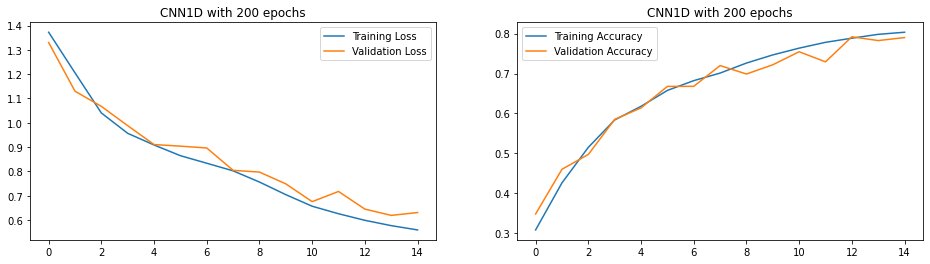

In [14]:
result_CNN1D = compile_train_model(CNN1D, 200)

In [ ]:
result_CNN1D['vocab_size'] = VOCAB_SIZE 
result_CNN1D['num_words'] = num_words 
result_CNN1D['num_articles'] = num_articles
result_CNN1D['min_token_in_a_article'] = min_token_in_a_article 
result_CNN1D['max_token_in_a_article'] = max_token_in_a_article 
new_col = ['1D CNN']   
result_CNN1D.insert(loc=0, column='Model', value=new_col)

In [ ]:
result_CNN1D

,Model,loss,accuracy,val_loss,val_accuracy,test_loss,test_accuracy,process_time,epochs_setting,epochs_actual,vocab_size,num_words,num_articles,min_token_in_a_article,max_token_in_a_article
2,1D CNN,0.0,0.249956,0.0,0.250833,0.0,0.25,237.795609,200,3,1000,114000,45,1360,2560


In [ ]:
#prev_results_df = pd.read_pickle('/content/gdrive/My Drive/Colab Notebooks/resultsB.pkl')
#assignment_result_table = prev_results_df.append(result_CNN1D,ignore_index=True)
#assignment_result_table

### Save Data

In [ ]:
result_CNN1D.to_pickle("/content/gdrive/My Drive/Colab Notebooks/resultsD.pkl") 
result_CNN1D.to_csv("/content/gdrive/My Drive/Colab Notebooks/resultsD.csv") 